Benchmarking SqPO rewriting with Neo4j
======================================



Types of rules
----------------
- Single transformation rules (given a node/edge a single clone/merge/add)
- Random rules with uniformly chosen operations (variable size of a lhs/number of operations)
- Rules extracted from the real-world dataset


Types of graphs
-----------------

#### Synthetic graphs


* Complete graph (Networkx's implementation)
 https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.generators.classic.complete_graph.html#networkx.generators.classic.complete_graph

* Directed scale-free graph (Networkx's implementation)

 **TODO:** investigate generation parameters $\alpha$, $\beta$, $\gamma$.
https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.generators.directed.scale_free_graph.html#networkx.generators.directed.scale_free_graph


References
-----------


* Benchmarking for Graph Transformation, Gergely Varr, Andy Schurr, Daniel Varr
  http://www.cs.bme.hu/~gervarro/publication/TUB-TR-05-EE17.pdf

* B. Bollobás, C. Borgs, J. Chayes, and O. Riordan, Directed scale-free graphs, Proceedings of the fourteenth annual ACM-SIAM Symposium on Discrete Algorithms, 132–139, 2003.



In [2]:
import time
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pickle
import importlib
import regraph
import uuid

from scipy import stats

from regraph import Rule, plot_rule, clone_node, merge_nodes, add_node, add_edge, remove_node, remove_edge
from regraph.neo4j.graphs import Neo4jGraph
from regraph.neo4j.cypher_utils import *

In [26]:
def clone_benchmark(graphs, samples=30):
    neo4j_full_clone = []
    neo4j_no_ids = []
    nx_clone = []
    # Collect statistics on clone
    for g in graphs:

        graph = nx.relabel_nodes(g, {n: "n" + str(n) for n in g.nodes()})
        
        print("Graph of size {}...".format(len(graph.nodes())))

        # dump graph into 'graph.csv'
        with open('/var/lib/neo4j/import/graph.csv', "w+") as f:
            f.write("uId,vId\n")
            for u, v in graph.edges():
                f.write("{},{}\n".format(u, v))

        # load csv into neo4j database
        neo4j_g.clear()
        load_csv_query =\
            "LOAD CSV WITH HEADERS FROM 'file:///graph.csv' AS csvLine " +\
            "MERGE (u:node {id: csvLine.uId }) " +\
            "MERGE (v:node {id: csvLine.vId }) " +\
            "CREATE (u)-[:edge]->(v) "
        neo4j_g.execute(load_csv_query)
        nodes = graph.nodes()

        # select 100 random nodes to clone
        random_nodes = np.random.choice(nodes, samples)

        # Clone with no pretty id's generation
        elapsed_times = []
        for node in random_nodes:
            start = time.time()
            res = neo4j_g.clone_node(node, ignore_naming=True)
            elapsed_times.append(time.time() - start)
        neo4j_no_ids.append((np.mean(elapsed_times), np.var(elapsed_times)))
    
        # Clone with pretty id's + ignore edges
        elapsed_times = []
        for node in random_nodes:
            start = time.time()
            res = neo4j_g.clone_node(node)
            elapsed_times.append(time.time() - start)
        neo4j_full_clone.append((np.mean(elapsed_times), np.var(elapsed_times)))

        # Clone with nx
        elapsed_times = []
        for node in random_nodes:
            start = time.time()
            res = clone_node(graph, node)
            elapsed_times.append(time.time() - start)
        nx_clone.append((np.mean(elapsed_times), np.var(elapsed_times)))
        
    return neo4j_full_clone, neo4j_no_ids, nx_clone

def merge_benchmark(graphs, samples=30):
    neo4j_full_merge = []
    neo4j_no_ids = []
    nx_merge = []
    # Collect statistics on merge
    for g in graphs:
        
        graph = nx.relabel_nodes(g, {n: "n" + str(n) for n in g.nodes()})
        
        print("Graph of size {}...".format(len(graph.nodes())))

        # dump graph into 'graph.csv'
        with open('/var/lib/neo4j/import/graph.csv', "w+") as f:
            f.write("uId,vId\n")
            for u, v in graph.edges():
                f.write("{},{}\n".format(u, v))

        # load csv into neo4j database
        neo4j_g.clear()
        load_csv_query =\
            "LOAD CSV WITH HEADERS FROM 'file:///graph.csv' AS csvLine " +\
            "MERGE (u:node {id: csvLine.uId }) " +\
            "MERGE (v:node {id: csvLine.vId }) " +\
            "CREATE (u)-[:edge]->(v) "
        neo4j_g.execute(load_csv_query)
        nodes = graph.nodes()

        # select random nodes to clone
        random_nodes1 = []
        random_nodes2 = []
        visited = set()

        # Clone with no pretty id's generation
        for i in range(samples):
            node1 = str(list(np.random.choice(nodes, 1))[0])
            node2 = str(list(np.random.choice(nodes, 1))[0])
            while node1 in visited or node2 in visited or node1 == node2:
                node1 = str(list(np.random.choice(nodes, 1))[0])
                node2 = str(list(np.random.choice(nodes, 1))[0])
            random_nodes1.append(node1)
            random_nodes2.append(node2)
            visited.add(node1)
            visited.add(node2)
            
        print(random_nodes1)
        print(random_nodes2)
            
        elapsed_times = []
        for i in range(len(random_nodes1)):
            node1 = random_nodes1[i]
            node2 = random_nodes2[i]

            start = time.time()
            res = neo4j_g.merge_nodes([node1, node2], ignore_naming=True)
            elapsed_times.append(time.time() - start)
        neo4j_no_ids.append((np.mean(elapsed_times), np.var(elapsed_times)))
        
        # load csv into neo4j database
        neo4j_g.clear()
        load_csv_query =\
            "LOAD CSV WITH HEADERS FROM 'file:///graph.csv' AS csvLine " +\
            "MERGE (u:node {id: csvLine.uId }) " +\
            "MERGE (v:node {id: csvLine.vId }) " +\
            "CREATE (u)-[:edge]->(v) "
        neo4j_g.execute(load_csv_query)
        nodes = graph.nodes()
        
        elapsed_times = []
        for i in range(len(random_nodes1)):
            node1 = random_nodes1[i]
            node2 = random_nodes2[i]

            start = time.time()
            res = neo4j_g.merge_nodes([node1, node2])
            elapsed_times.append(time.time() - start)
        neo4j_full_merge.append((np.mean(elapsed_times), np.var(elapsed_times)))

        # Clone with nx
        elapsed_times = []
        for i in range(len(random_nodes1)):
            node1 = random_nodes1[i]
            node2 = random_nodes2[i]

            start = time.time()
            res = merge_nodes(graph, [node1, node2])
            elapsed_times.append(time.time() - start)
        nx_merge.append((np.mean(elapsed_times), np.var(elapsed_times)))
        
    return neo4j_full_merge, neo4j_no_ids, nx_merge


def add_node_benchmark(graphs, samples=30):
    neo4j_full_add = []
    neo4j_no_ids = []
    nx_add = []
    # Collect statistics on clone
    for g in graphs:

        graph = nx.relabel_nodes(g, {n: "n" + str(n) for n in g.nodes()})
        
        print("Graph of size {}...".format(len(graph.nodes())))

        # dump graph into 'graph.csv'
        with open('/var/lib/neo4j/import/graph.csv', "w+") as f:
            f.write("uId,vId\n")
            for u, v in graph.edges():
                f.write("{},{}\n".format(u, v))

        # load csv into neo4j database
        neo4j_g.clear()
        load_csv_query =\
            "LOAD CSV WITH HEADERS FROM 'file:///graph.csv' AS csvLine " +\
            "MERGE (u:node {id: csvLine.uId }) " +\
            "MERGE (v:node {id: csvLine.vId }) " +\
            "CREATE (u)-[:edge]->(v) "
        neo4j_g.execute(load_csv_query)
        nodes = graph.nodes()

        # generate random nodes to add
        random_nodes = ["uid" + str(uuid.uuid4()).replace("-", "") for n in range(samples)]

        # Clone with no pretty id's generation
        elapsed_times = []
        for node in random_nodes:
            start = time.time()
            res = neo4j_g.add_node(node, ignore_naming=True)
            elapsed_times.append(time.time() - start)
        neo4j_no_ids.append((np.mean(elapsed_times), np.var(elapsed_times)))
    
        # Clone with pretty id's + ignore edges
        elapsed_times = []
        for node in random_nodes:
            start = time.time()
            res = neo4j_g.add_node(node)
            elapsed_times.append(time.time() - start)
        neo4j_full_add.append((np.mean(elapsed_times), np.var(elapsed_times)))

        # Clone with nx
        elapsed_times = []
        for node in random_nodes:
            start = time.time()
            res = add_node(graph, node)
            elapsed_times.append(time.time() - start)
        nx_add.append((np.mean(elapsed_times), np.var(elapsed_times)))
        
    return neo4j_full_add, neo4j_no_ids, nx_add

def add_edge_benchmark(graphs, samples):
    # Connect the db
    neo4j_g = Neo4jGraph("bolt://localhost:7687", "neo4j", "admin") 

    neo4j_add_edge = []
    nx_add_edge = []
    # Collect statistics on merge
    for g in graphs:
        
        graph = nx.relabel_nodes(g, {n: "n" + str(n) for n in g.nodes()})
        
        print("Graph of size {}...".format(len(graph.nodes())))

        # dump graph into 'graph.csv'
        with open('/var/lib/neo4j/import/graph.csv', "w+") as f:
            f.write("uId,vId\n")
            for u, v in graph.edges():
                f.write("{},{}\n".format(u, v))

        # load csv into neo4j database
        neo4j_g.clear()
        load_csv_query =\
            "LOAD CSV WITH HEADERS FROM 'file:///graph.csv' AS csvLine " +\
            "MERGE (u:node {id: csvLine.uId }) " +\
            "MERGE (v:node {id: csvLine.vId }) " +\
            "CREATE (u)-[:edge]->(v) "
        neo4j_g.execute(load_csv_query)
        nodes = graph.nodes()

        # select random nodes to add edge
        # generate random nodes to add
        random_nodes1 = ["uid" + str(uuid.uuid4()).replace("-", "") for n in range(samples)]
        random_nodes2 = []
        visited = set()

        # Clone with no pretty id's generation
        for node1 in random_nodes1:
            node2 = str(list(np.random.choice(nodes, 1))[0])
            while (node1, node2) in visited:
                node2 = str(list(np.random.choice(nodes, 1))[0])
            random_nodes2.append(node2)
            visited.add((node1, node2))
            
        elapsed_times = []
        for i in range(len(random_nodes1)):
            node1 = random_nodes1[i]
            node2 = random_nodes2[i]

            neo4j_g.add_node(node1)

            start = time.time()
            res = neo4j_g.add_edge(node1, node2)
            elapsed_times.append(time.time() - start)
        print("Neo4j")
        print(np.mean(elapsed_times), np.var(elapsed_times))
        neo4j_add_edge.append((np.mean(elapsed_times), np.var(elapsed_times)))
        
        # add edge with nx
        elapsed_times = []
        for i in range(len(random_nodes1)):
            node1 = random_nodes1[i]
            node2 = random_nodes2[i]

            add_node(graph, node1)

            start = time.time()
            res = add_edge(graph, node1, node2)
            elapsed_times.append(time.time() - start)
        print("Nx")
        print(np.mean(elapsed_times), np.var(elapsed_times))
        nx_add_edge.append((np.mean(elapsed_times), np.var(elapsed_times)))
    return neo4j_add_edge, nx_add_edge      

def remove_node_benchmark(graphs):
    pass

def remove_edge_benchmark(graphs):
    pass

def individual_benchmark(graphs, samples=30):
    
    new_graphs = []
    for g in graphs:
        simple_g = nx.DiGraph()
        simple_g.add_nodes_from(g.nodes())
        simple_g.add_edges_from(set(g.edges()))
        new_graphs.append(simple_g)
    
    stats = {
        "neo4j": {},
        "nx": {}
    }
    
    (stats["neo4j"]["full_clone"],
     stats["neo4j"]["no_id_gen_clone"],
     stats["nx"]["clone"]) = clone_benchmark(graphs, samples)

    (stats["neo4j"]["full_merge"],
     stats["neo4j"]["no_id_gen_merge"],
     stats["nx"]["merge"]) = merge_benchmark(new_graphs, samples)
    
    (stats["neo4j"]["full_add"],
     stats["neo4j"]["no_id_gen_add"],
     stats["nx"]["add"]) = add_node_benchmark(new_graphs, samples)
    
    (stats["neo4j"]["add_edge"],
     stats["nx"]["add_edge"]) = add_edge_benchmark(new_graphs, samples)
    
    return stats

In [4]:
import statsmodels.api as sm

def detect_outliers(x, y):
    log_x = np.log2(x)
    log_y = np.log2(y)
    lm = sm.OLS(log_x, log_y).fit()
    test =lm.outlier_test()
    outliers = np.where(test[:, 2] < 0.5)[0]
    return outliers.tolist()

/home/eugenia/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
def plot_stat(stats, ns, datatitle=None, log=False):
    fig = plt.figure(figsize=(10, 20))
    
    y1 = [v[0] for v in stats["nx"]["clone"]]
    y2 = [v[0] for v in stats["neo4j"]["full_clone"]]
    y3 = [v[0] for v in stats["neo4j"]["no_id_gen_clone"]]

    outliers = set(
        detect_outliers(ns, y1) +
        detect_outliers(ns, y2) +
        detect_outliers(ns, y3))

    filtered_indices = [i for i in range(len(y1)) if i not in outliers]
    x = np.take(ns, filtered_indices)
    y1 = np.take(y1, filtered_indices)
    y2 = np.take(y2, filtered_indices)
    y3 = np.take(y3, filtered_indices)
                                         
    ax = fig.add_subplot(411)
    ax.plot(
        x, y1, "bo",
        x, y2, "ro", 
        x, y3, "go")
    ax.set_xscale('log')
    if log is True:
        ax.set_yscale('log')
    ax.set_title('Time to clone a node')
    ax.set_xlabel('N, size of a graph')
    ax.set_ylabel('Time to clone a node in ms')
    ax.legend(["NetworkX", "Neo4j basic", "Neo4j no ids"])
    
    
    y1 = [v[0] for v in stats["nx"]["add"]]
    y2 = [v[0] for v in stats["neo4j"]["full_add"]]
    y3 = [v[0] for v in stats["neo4j"]["no_id_gen_add"]]
                                         
    outliers = set(
        detect_outliers(ns, y1) +
        detect_outliers(ns, y2) +
        detect_outliers(ns, y3))

    filtered_indices = [i for i in range(len(y1)) if i not in outliers]
    x = np.take(ns, filtered_indices)
    y1 = np.take(y1, filtered_indices)
    y2 = np.take(y2, filtered_indices)
    y3 = np.take(y3, filtered_indices)

    ax = fig.add_subplot(412)
    ax.plot(
        x, y1, "bo",
        x, y2, "ro", 
        x, y3, "go")
    ax.set_xscale('log')
    if log is True:
        ax.set_yscale('log')
    ax.set_title('Time to add a node')
    ax.set_xlabel('N, size of a graph')
    ax.set_ylabel('Time to add a node in ms')
    ax.legend(["NetworkX", "Neo4j basic", "Neo4j no ids"])
    
    y1 = [v[0] for v in stats["nx"]["merge"]]
    y2 = [v[0] for v in stats["neo4j"]["full_merge"]]
    y3 = [v[0] for v in stats["neo4j"]["no_id_gen_merge"]]
                                         
    outliers = set(
        detect_outliers(ns, y1) +
        detect_outliers(ns, y2) +
        detect_outliers(ns, y3))

    filtered_indices = [i for i in range(len(y1)) if i not in outliers]
    x = np.take(ns, filtered_indices)
    y1 = np.take(y1, filtered_indices)
    y2 = np.take(y2, filtered_indices)
    y3 = np.take(y3, filtered_indices)

    ax = fig.add_subplot(413)
    ax.plot(
        x, y1, "bo",
        x, y2, "ro", 
        x, y3, "go")
    ax.set_xscale('log')
    if log is True:
        ax.set_yscale('log')
    ax.set_title('Time to merge two node')
    ax.set_xlabel('N, size of a graph')
    ax.set_ylabel('Time to merge two node in ms')
    ax.legend(["NetworkX", "Neo4j basic", "Neo4j no ids"])
    
    y1 = [v[0] for v in stats["nx"]["add_edge"]]
    y2 = [v[0] for v in stats["neo4j"]["add_edge"]]
                                         
                                         
    outliers = set(
        detect_outliers(ns, y1) +
        detect_outliers(ns, y2))
 
    filtered_indices = [i for i in range(len(y1)) if i not in outliers]
    x = np.take(ns, filtered_indices)
    y1 = np.take(y1, filtered_indices)
    y2 = np.take(y2, filtered_indices)

    ax = fig.add_subplot(414)
    ax.plot(
        x, y1, "bo",
        x, y2, "ro")
    ax.set_xscale('log')
    if log is True:
        ax.set_yscale('log')
    ax.set_title('Time to add an edge')
    ax.set_xlabel('N, size of a graph')
    ax.set_ylabel('Time in ms')
    ax.legend(["NetworkX", "Neo4j basic"])
    
    plt.show()

In [6]:
def plot_aggregated_stat(stats, ns, datatitle=None, log=False):
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111)

    y1 = [v[0] for v in stats["nx"]["clone"]]
    y2 = [v[0] for v in stats["neo4j"]["full_clone"]]
    y3 = [v[0] for v in stats["neo4j"]["no_id_gen_clone"]]

    outliers = set(
        detect_outliers(ns, y1) +
        detect_outliers(ns, y2) +
        detect_outliers(ns, y3))

    filtered_indices = [i for i in range(len(y1)) if i not in outliers]
    x = np.take(ns, filtered_indices)
    y1 = np.take(y1, filtered_indices)
    y2 = np.take(y2, filtered_indices)
    y3 = np.take(y3, filtered_indices)
                                         
    ax.plot(
        x, y1, "ro",
        x, y2, "r^", 
        x, y3, "rs")
    ax.set_xscale('log')
    if log is True:
        ax.set_yscale('log')
#     ax.set_title('Time to clone a node')
#     ax.set_xlabel('N, size of a graph')
#     ax.set_ylabel('Time to clone a node in ms')
#     ax.legend(["NetworkX", "Neo4j basic", "Neo4j no ids"])
    
    y1 = [v[0] for v in stats["nx"]["add"]]
    y2 = [v[0] for v in stats["neo4j"]["full_add"]]
    y3 = [v[0] for v in stats["neo4j"]["no_id_gen_add"]]
                                         
    outliers = set(
        detect_outliers(ns, y1) +
        detect_outliers(ns, y2) +
        detect_outliers(ns, y3))

    filtered_indices = [i for i in range(len(y1)) if i not in outliers]
    x = np.take(ns, filtered_indices)
    y1 = np.take(y1, filtered_indices)
    y2 = np.take(y2, filtered_indices)
    y3 = np.take(y3, filtered_indices)

#     ax = fig.add_subplot(412)
    ax.plot(
        x, y1, "bo",
        x, y2, "b^", 
        x, y3, "bs")
#     ax.set_xscale('log')
#     if log is True:
#         ax.set_yscale('log')
#     ax.set_title('Time to add a node')
#     ax.set_xlabel('N, size of a graph')
#     ax.set_ylabel('Time to add a node in ms')
#     ax.legend(["NetworkX", "Neo4j basic", "Neo4j no ids"])
    
    y1 = [v[0] for v in stats["nx"]["merge"]]
    y2 = [v[0] for v in stats["neo4j"]["full_merge"]]
    y3 = [v[0] for v in stats["neo4j"]["no_id_gen_merge"]]
                                         
    outliers = set(
        detect_outliers(ns, y1) +
        detect_outliers(ns, y2) +
        detect_outliers(ns, y3))

    filtered_indices = [i for i in range(len(y1)) if i not in outliers]
    x = np.take(ns, filtered_indices)
    y1 = np.take(y1, filtered_indices)
    y2 = np.take(y2, filtered_indices)
    y3 = np.take(y3, filtered_indices)

#     ax = fig.add_subplot(413)
    ax.plot(
        x, y1, "go",
        x, y2, "g^", 
        x, y3, "gs")
#     ax.set_xscale('log')
#     if log is True:
#         ax.set_yscale('log')
#     ax.set_title('Time to merge two node')
#     ax.set_xlabel('N, size of a graph')
#     ax.set_ylabel('Time to merge two node in ms')
#     ax.legend(["NetworkX", "Neo4j basic", "Neo4j no ids"])
    
    y1 = [v[0] for v in stats["nx"]["add_edge"]]
    y2 = [v[0] for v in stats["neo4j"]["add_edge"]]
                                                                           
    outliers = set(
        detect_outliers(ns, y1) +
        detect_outliers(ns, y2))
 
    filtered_indices = [i for i in range(len(y1)) if i not in outliers]
    x = np.take(ns, filtered_indices)
    y1 = np.take(y1, filtered_indices)
    y2 = np.take(y2, filtered_indices)

#     ax = fig.add_subplot(414)
#     ax.plot(
#         x, y1, "bo",
#         x, y2, "ro")
#     ax.set_xscale('log')
    if log is True:
        ax.set_yscale('log')
    ax.set_title('Time to add an edge')
    ax.set_xlabel('N, size of a graph')
    ax.set_ylabel('Time in ms')
    ax.legend(["NetworkX", "Neo4j basic"])
    
    plt.show()

In [7]:
# Connect the db
neo4j_g = Neo4jGraph("bolt://localhost:7687", "neo4j", "admin")

In [38]:
# scale_free_stats = individual_benchmark(logspaced_scale_free[10:], 20)
# with open("scale_free_stats.pickle", "wb") as f:
#     pickle.dump(scale_free_stats, f)

Graph of size 48...
Graph of size 50...
Graph of size 52...
Graph of size 55...
Graph of size 57...
Graph of size 59...
Graph of size 62...
Graph of size 65...
Graph of size 67...
Graph of size 70...
Graph of size 73...
Graph of size 76...
Graph of size 80...
Graph of size 83...
Graph of size 87...
Graph of size 90...
Graph of size 94...
Graph of size 98...
Graph of size 103...
Graph of size 107...
Graph of size 112...
Graph of size 116...
Graph of size 121...
Graph of size 127...
Graph of size 132...
Graph of size 138...
Graph of size 144...
Graph of size 150...
Graph of size 156...
Graph of size 163...
Graph of size 170...
Graph of size 177...
Graph of size 185...
Graph of size 193...
Graph of size 201...
Graph of size 209...
Graph of size 218...
Graph of size 228...
Graph of size 237...
Graph of size 248...
Graph of size 258...
Graph of size 269...
Graph of size 281...
Graph of size 293...
Graph of size 305...
Graph of size 318...
Graph of size 332...
Graph of size 346...
Graph of s

Graph of size 107...
['n89', 'n38', 'n88', 'n83', 'n43', 'n32', 'n65', 'n14', 'n30', 'n25', 'n96', 'n21', 'n86', 'n5', 'n74', 'n27', 'n41', 'n19', 'n17', 'n91']
['n61', 'n78', 'n57', 'n53', 'n2', 'n10', 'n92', 'n63', 'n95', 'n8', 'n44', 'n34', 'n62', 'n22', 'n56', 'n18', 'n103', 'n94', 'n97', 'n39']
Graph of size 112...
['n85', 'n111', 'n5', 'n76', 'n96', 'n62', 'n54', 'n61', 'n6', 'n43', 'n50', 'n28', 'n46', 'n79', 'n92', 'n3', 'n38', 'n48', 'n89', 'n71']
['n14', 'n107', 'n103', 'n64', 'n80', 'n99', 'n75', 'n45', 'n34', 'n95', 'n21', 'n55', 'n110', 'n63', 'n58', 'n0', 'n94', 'n26', 'n29', 'n20']
Graph of size 116...
['n72', 'n43', 'n19', 'n20', 'n105', 'n115', 'n21', 'n110', 'n101', 'n104', 'n78', 'n7', 'n32', 'n69', 'n90', 'n114', 'n109', 'n68', 'n51', 'n111']
['n75', 'n10', 'n2', 'n71', 'n37', 'n0', 'n48', 'n107', 'n58', 'n30', 'n24', 'n1', 'n45', 'n29', 'n85', 'n108', 'n88', 'n102', 'n16', 'n97']
Graph of size 121...
['n9', 'n93', 'n92', 'n101', 'n28', 'n109', 'n37', 'n87', 'n90', 

Graph of size 318...
['n263', 'n97', 'n32', 'n45', 'n272', 'n281', 'n248', 'n30', 'n23', 'n290', 'n9', 'n65', 'n27', 'n249', 'n7', 'n114', 'n6', 'n260', 'n72', 'n237']
['n180', 'n215', 'n274', 'n197', 'n292', 'n169', 'n41', 'n273', 'n110', 'n155', 'n66', 'n195', 'n86', 'n174', 'n314', 'n95', 'n301', 'n141', 'n173', 'n308']
Graph of size 332...
['n35', 'n299', 'n270', 'n205', 'n271', 'n218', 'n107', 'n280', 'n43', 'n54', 'n114', 'n223', 'n258', 'n128', 'n236', 'n64', 'n73', 'n111', 'n225', 'n8']
['n188', 'n235', 'n230', 'n7', 'n148', 'n324', 'n274', 'n69', 'n147', 'n159', 'n120', 'n142', 'n281', 'n157', 'n263', 'n243', 'n154', 'n255', 'n96', 'n57']
Graph of size 346...
['n18', 'n306', 'n87', 'n254', 'n316', 'n48', 'n30', 'n76', 'n193', 'n267', 'n277', 'n116', 'n298', 'n156', 'n112', 'n145', 'n194', 'n140', 'n149', 'n239']
['n269', 'n256', 'n26', 'n253', 'n36', 'n241', 'n171', 'n90', 'n11', 'n341', 'n121', 'n184', 'n61', 'n21', 'n199', 'n80', 'n234', 'n258', 'n46', 'n273']
Graph of size 

Graph of size 906...
['n484', 'n327', 'n325', 'n387', 'n249', 'n838', 'n196', 'n84', 'n69', 'n390', 'n714', 'n807', 'n202', 'n645', 'n599', 'n30', 'n667', 'n44', 'n505', 'n230']
['n62', 'n569', 'n164', 'n762', 'n638', 'n65', 'n886', 'n308', 'n426', 'n521', 'n786', 'n356', 'n123', 'n869', 'n766', 'n617', 'n311', 'n388', 'n441', 'n324']
Graph of size 945...
['n345', 'n625', 'n265', 'n887', 'n275', 'n233', 'n418', 'n194', 'n77', 'n193', 'n314', 'n344', 'n616', 'n905', 'n787', 'n169', 'n453', 'n522', 'n42', 'n283']
['n478', 'n484', 'n219', 'n774', 'n461', 'n574', 'n694', 'n493', 'n236', 'n802', 'n70', 'n939', 'n466', 'n212', 'n83', 'n922', 'n534', 'n629', 'n739', 'n35']
Graph of size 985...
['n32', 'n679', 'n478', 'n822', 'n405', 'n584', 'n918', 'n110', 'n512', 'n771', 'n619', 'n151', 'n897', 'n158', 'n626', 'n452', 'n818', 'n863', 'n448', 'n794']
['n178', 'n877', 'n677', 'n783', 'n802', 'n62', 'n332', 'n744', 'n933', 'n827', 'n126', 'n767', 'n904', 'n467', 'n152', 'n46', 'n373', 'n453', '

Graph of size 2471...
['n220', 'n1451', 'n214', 'n1364', 'n1488', 'n799', 'n1418', 'n197', 'n33', 'n1900', 'n659', 'n1647', 'n1737', 'n1407', 'n1947', 'n959', 'n910', 'n296', 'n733', 'n1492']
['n1589', 'n1523', 'n286', 'n285', 'n2361', 'n2179', 'n1030', 'n2133', 'n1474', 'n700', 'n136', 'n2068', 'n2386', 'n2170', 'n295', 'n1571', 'n1911', 'n2259', 'n982', 'n2382']
Graph of size 2577...
['n161', 'n2424', 'n685', 'n186', 'n949', 'n2194', 'n960', 'n1880', 'n1404', 'n805', 'n1147', 'n172', 'n1416', 'n651', 'n1236', 'n900', 'n196', 'n1892', 'n340', 'n560']
['n1407', 'n2428', 'n2115', 'n620', 'n2079', 'n279', 'n729', 'n1199', 'n2210', 'n1631', 'n475', 'n829', 'n2075', 'n2333', 'n1447', 'n226', 'n1175', 'n2100', 'n753', 'n2207']
Graph of size 2687...
['n1143', 'n1039', 'n2670', 'n124', 'n1533', 'n85', 'n2120', 'n359', 'n1168', 'n2340', 'n1224', 'n107', 'n2503', 'n2630', 'n1599', 'n192', 'n129', 'n2378', 'n1947', 'n829']
['n316', 'n1830', 'n994', 'n1655', 'n835', 'n934', 'n1496', 'n42', 'n1160

['n5288', 'n2453', 'n335', 'n2588', 'n1903', 'n2609', 'n1365', 'n3550', 'n4329', 'n1376', 'n1017', 'n2259', 'n2506', 'n1952', 'n869', 'n4322', 'n4792', 'n2796', 'n2326', 'n5488']
['n2608', 'n1877', 'n3189', 'n1372', 'n2935', 'n1853', 'n5240', 'n1497', 'n5471', 'n90', 'n6157', 'n2561', 'n2928', 'n3019', 'n3568', 'n2661', 'n5958', 'n4303', 'n6155', 'n1351']
Graph of size 6464...
['n4177', 'n304', 'n2026', 'n4206', 'n5801', 'n3829', 'n3692', 'n2700', 'n5775', 'n4886', 'n3610', 'n1232', 'n2994', 'n1160', 'n301', 'n3001', 'n1478', 'n3699', 'n3711', 'n5560']
['n5258', 'n1282', 'n3292', 'n1324', 'n5013', 'n4807', 'n4863', 'n4341', 'n4796', 'n5074', 'n5001', 'n5807', 'n2635', 'n5318', 'n4517', 'n4883', 'n3977', 'n4262', 'n143', 'n6261']
Graph of size 6740...
['n5320', 'n4288', 'n5133', 'n100', 'n5715', 'n509', 'n1138', 'n4236', 'n1910', 'n5730', 'n5671', 'n1206', 'n4278', 'n2061', 'n3102', 'n4290', 'n6698', 'n900', 'n575', 'n6416']
['n4612', 'n5891', 'n4804', 'n2150', 'n6290', 'n5592', 'n2151'

Graph of size 3453...
Graph of size 3600...
Graph of size 3754...
Graph of size 3914...
Graph of size 4081...
Graph of size 4255...
Graph of size 4437...
Graph of size 4627...
Graph of size 4824...
Graph of size 5030...
Graph of size 5245...
Graph of size 5469...
Graph of size 5702...
Graph of size 5945...
Graph of size 6199...
Graph of size 6464...
Graph of size 6740...
Graph of size 7027...
Graph of size 7327...
Graph of size 7640...
Graph of size 7966...
Graph of size 8306...
Graph of size 8661...
Graph of size 9031...
Graph of size 9416...
Graph of size 9818...
Graph of size 10237...
Graph of size 10674...
Graph of size 11130...
Graph of size 11605...
Graph of size 48...
Graph of size 50...
Graph of size 52...
Graph of size 55...
Graph of size 57...
Graph of size 59...
Graph of size 62...
Graph of size 65...
Graph of size 67...
Graph of size 70...
Graph of size 73...
Graph of size 76...
Graph of size 80...
Graph of size 83...
Graph of size 87...
Graph of size 90...
Graph of size 94

In [13]:
with open("scale_free_stats.pickle", "rb") as f:
    scale_free_stats = pickle.load(f)
scale_free_ns = [int(i) for i in np.logspace(5, 17, 200, base=2)][10:142]

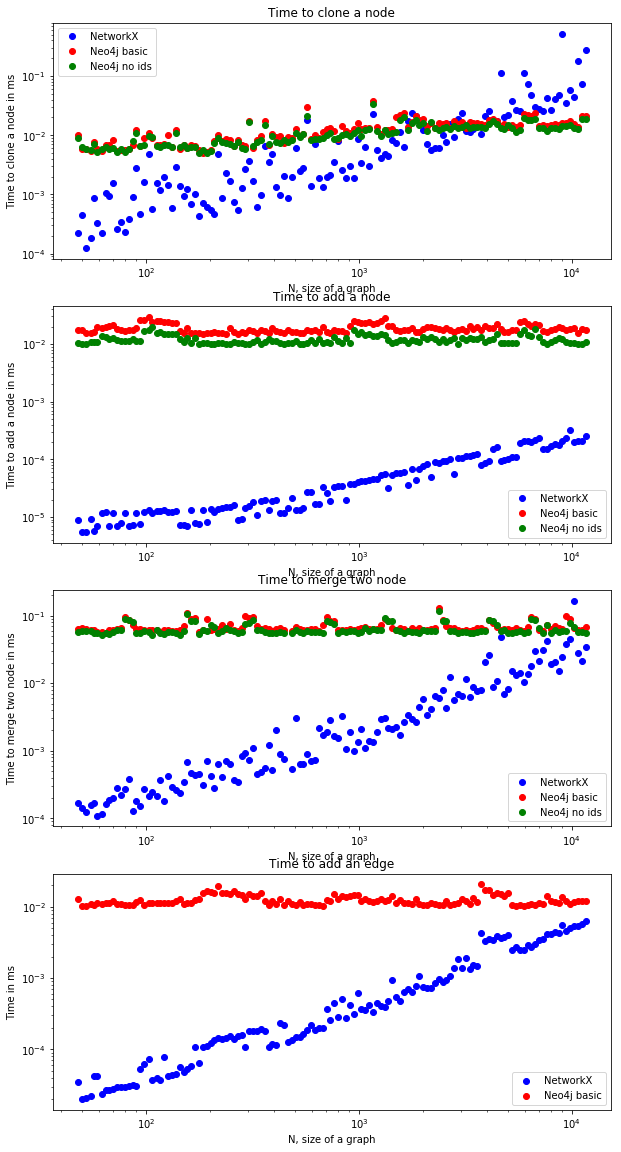

In [14]:
plot_stat(scale_free_stats, scale_free_ns, log=True)

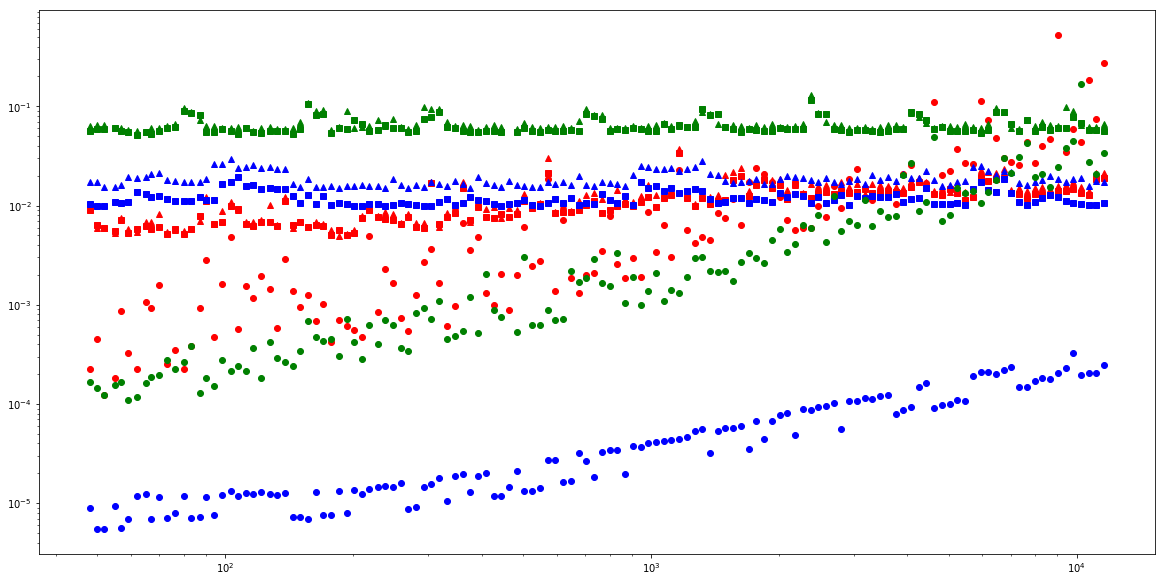

In [17]:
plot_aggregated_stat(scale_free_stats, scale_free_ns, log=True)

In [19]:
with open("logspaced_cliques.pickle", "rb") as f:
    (clique_ns, logspaced_cliques) = pickle.load(f)

In [24]:
clique_stats = individual_benchmark(logspaced_cliques[3:], 20)

Graph of size 44...
Graph of size 49...
Graph of size 55...
Graph of size 61...
Graph of size 68...
Graph of size 76...
Graph of size 85...
Graph of size 95...
Graph of size 106...
Graph of size 118...
Graph of size 132...
Graph of size 148...
Graph of size 165...
Graph of size 184...
Graph of size 205...
Graph of size 229...
Graph of size 256...
Graph of size 44...
['nn38', 'nn9', 'nn24', 'nn31', 'nn3', 'nn22', 'nn13', 'nn29', 'nn36', 'nn27', 'nn14', 'nn20', 'nn21', 'nn17', 'nn18', 'nn39', 'nn40', 'nn44', 'nn2', 'nn4']
['nn25', 'nn35', 'nn6', 'nn28', 'nn7', 'nn19', 'nn26', 'nn32', 'nn5', 'nn43', 'nn37', 'nn15', 'nn30', 'nn12', 'nn11', 'nn1', 'nn23', 'nn16', 'nn41', 'nn34']
Graph of size 49...
['nn46', 'nn47', 'nn29', 'nn10', 'nn12', 'nn1', 'nn35', 'nn40', 'nn49', 'nn34', 'nn6', 'nn18', 'nn43', 'nn37', 'nn25', 'nn15', 'nn41', 'nn17', 'nn9', 'nn22']
['nn23', 'nn20', 'nn19', 'nn2', 'nn24', 'nn38', 'nn21', 'nn27', 'nn8', 'nn26', 'nn48', 'nn11', 'nn28', 'nn31', 'nn30', 'nn5', 'nn16', 'nn14

KeyboardInterrupt: 

In [ ]:
with open("clique_stats.pickle", "wb") as f:
    pickle.dump(clique_stats, f)

## Mean elapsed time to perform a single operation

### Complete directed graphs (cliques)

In [2]:
# # Generate graphs (Warning: takes some time, see below dumped graphs)
# clique_ns = [int(i) for i in np.logspace(5, 8, 20, base=2)]

# logspaced_cliques = []
# for n in clique_ns:
#     g = nx.DiGraph()
#     nodelist = ["n" + str(nn + 1)for nn in range(n)]
#     g.add_nodes_from(nodelist)
#     edges = []
#     for n1 in nodelist:
#         for n2 in nodelist:
#             edges.append((n1, n2))
#             edges.append((n2, n1))
#     g.add_edges_from(edges)
#     logspaced_cliques.append(g)
# with open("logspaced_cliques.pickle","wb") as f:
#     pickle.dump((clique_ns, logspaced_cliques), f)

In [13]:
# Connect the db
neo4j_g = Neo4jGraph("bolt://localhost:7687", "neo4j", "admin")

In [14]:
# Collect statistics on clone
for graph in logspaced_cliques:
    print("Graph of size {}...".format(len(graph.nodes())))

    # dump graph into 'graph.csv'
    with open('/var/lib/neo4j/import/graph.csv', "w+") as f:
        f.write("uId,vId\n")
        for u, v in graph.edges():
            f.write("{},{}\n".format(u, v))

    # load csv into neo4j database
    neo4j_g.clear()
    load_csv_query =\
        "LOAD CSV WITH HEADERS FROM 'file:///graph.csv' AS csvLine " +\
        "MERGE (u:node {id: csvLine.uId }) " +\
        "MERGE (v:node {id: csvLine.vId }) " +\
        "CREATE (u)-[:edge]->(v) "
    neo4j_g.execute(load_csv_query)
    nodes = graph.nodes()

    # select 100 random nodes to clone
    random_nodes = np.random.choice(nodes, 30)
    
    # Clone with no pretty id's generation
    elapsed_times = []
    for node in random_nodes:
        start = time.time()
        res = neo4j_g.clone_node(node, ignore_naming=True)
        elapsed_times.append(time.time() - start)
    neo4j_clique["no_id_gen_clone"].append(np.mean(elapsed_times))
  
    # Clone with pretty id's + ignore edges
    elapsed_times = []
    for node in random_nodes:
        start = time.time()
        res = neo4j_g.clone_node(node)
        elapsed_times.append(time.time() - start)
    neo4j_clique["full_clone"].append(np.mean(elapsed_times))

    # Clone with nx
    elapsed_times = []
    for node in random_nodes:
        start = time.time()
        res = clone_node(graph, node)
        elapsed_times.append(time.time() - start)
    nx_clique["clone"].append(np.mean(elapsed_times))

with open("nx_clique.pickle", "wb") as f:
    pickle.dump(nx_clique, f)

with open("neo4j_clique.pickle", "wb") as f:
    pickle.dump(neo4j_clique, f)

Graph of size 32...
Graph of size 35...
Graph of size 39...


KeyboardInterrupt: 

Exception ignored in: 'neo4j.bolt._io.ChunkedInputBuffer.receive'
Traceback (most recent call last):
  File "/home/eugenia/anaconda3/lib/python3.6/ssl.py", line 1009, in recv_into
    return self.read(nbytes, buffer)
  File "/home/eugenia/anaconda3/lib/python3.6/ssl.py", line 871, in read
    return self._sslobj.read(len, buffer)
  File "/home/eugenia/anaconda3/lib/python3.6/ssl.py", line 631, in read
    v = self._sslobj.read(len, buffer)
KeyboardInterrupt: 


ServiceUnavailable: Failed to read from defunct connection Address(host='127.0.0.1', port=7687)

In [18]:
# # Collect statistics on clone
# for graph in logspaced_cliques[:10]:
#     print("Graph of size {}...".format(len(graph.nodes())))

#     # dump graph into 'graph.csv'
#     with open('/var/lib/neo4j/import/graph.csv', "w+") as f:
#         f.write("uId,vId\n")
#         for u, v in graph.edges():
#             f.write("{},{}\n".format(u, v))

#     # load csv into neo4j database
#     neo4j_g.clear()
#     load_csv_query =\
#         "LOAD CSV WITH HEADERS FROM 'file:///graph.csv' AS csvLine " +\
#         "MERGE (u:node {id: csvLine.uId }) " +\
#         "MERGE (v:node {id: csvLine.vId }) " +\
#         "CREATE (u)-[:edge]->(v) "
#     neo4j_g.execute(load_csv_query)
#     nodes = graph.nodes()

#     # select 100 random nodes to clone
#     random_nodes1 = np.random.choice(nodes, 30)
#     random_nodes2 = np.random.choice(nodes, 30)
    
#     # Clone with no pretty id's generation
#     elapsed_times = []
#     for i in range(len(random_nodes1)):
#         print("neo4j")
#         node1 = random_nodes1[i]
#         node2 = random_nodes2[i]
#         if node1 != node2:
#             start = time.time()
#             res = neo4j_g.merge_nodes([node1, node2], ignore_naming=True)
#             elapsed_times.append(time.time() - start)
#     neo4j_clique["no_id_gen_merge"].append(np.mean(elapsed_times))
  
#     # load csv into neo4j database
#     neo4j_g.clear()
#     load_csv_query =\
#         "LOAD CSV WITH HEADERS FROM 'file:///graph.csv' AS csvLine " +\
#         "MERGE (u:node {id: csvLine.uId }) " +\
#         "MERGE (v:node {id: csvLine.vId }) " +\
#         "CREATE (u)-[:edge]->(v) "
#     neo4j_g.execute(load_csv_query)
#     nodes = graph.nodes()

#     # Clone with pretty id's + ignore edges
#     elapsed_times = []
#     for i in range(len(random_nodes1)):
#         print("neo4j2")
#         node1 = random_nodes1[i]
#         node2 = random_nodes2[i]
#         if node1 != node2:
#             start = time.time()
#             res = neo4j_g.merge_nodes([node1, node2])
#             elapsed_times.append(time.time() - start)
#     neo4j_clique["full_merge"].append(np.mean(elapsed_times))

#     # Clone with nx
#     elapsed_times = []
#     for i in range(len(random_nodes1)):
#         print("nx")
#         node1 = random_nodes1[i]
#         node2 = random_nodes2[i]
#         if node1 != node2:
#             start = time.time()
#             res = merge_nodes(graph, [node1, node2])
#             elapsed_times.append(time.time() - start)
#     nx_clique["merge"].append(np.mean(elapsed_times))

# # with open("nx_clique.pickle", "wb") as f:
# #     pickle.dump(nx_clique, f)

# # with open("neo4j_clique.pickle", "wb") as f:
# #     pickle.dump(neo4j_clique, f)

Graph of size 62...
neo4j
CREATE (merged_node:node) SET merged_node.id=toString(id(merged_node)) WITH toString(id(merged_node)) as new_id , n13, n110, sucs_n13, preds_n13, sucs_n110, preds_n110, merged_node 
MATCH (n110:node { id : 'n110'}), (n13:node { id : 'n13'}) OPTIONAL MATCH (n110)-[:edge]->(suc_n110) OPTIONAL MATCH (pred_n110)-[:edge]->(n110) OPTIONAL MATCH (n13)-[:edge]->(suc_n13) OPTIONAL MATCH (pred_n13)-[:edge]->(n13)  WITH COLLECT(suc_n110) as sucs_n110, COLLECT(pred_n110) as preds_n110, COLLECT(suc_n13) as sucs_n13, COLLECT(pred_n13) as preds_n13, n13, n110 CREATE (merged_node:node) SET merged_node.id=toString(id(merged_node)) WITH toString(id(merged_node)) as new_id , n13, n110, sucs_n13, preds_n13, sucs_n110, preds_n110, merged_node FOREACH(s IN sucs_n110 | CREATE UNIQUE (merged_node)-[:edge]->(s))  FOREACH(s IN sucs_n13 | CREATE UNIQUE (merged_node)-[:edge]->(s)) FOREACH(p IN preds_n110 | CREATE UNIQUE (p)-[:edge]->(merged_node))  FOREACH(p IN preds_n13 | CREATE UNIQUE 

KeyboardInterrupt: 

Exception ignored in: 'neo4j.bolt._io.ChunkedInputBuffer.receive'
Traceback (most recent call last):
  File "/home/eugenia/anaconda3/lib/python3.6/ssl.py", line 1009, in recv_into
    return self.read(nbytes, buffer)
  File "/home/eugenia/anaconda3/lib/python3.6/ssl.py", line 871, in read
    return self._sslobj.read(len, buffer)
  File "/home/eugenia/anaconda3/lib/python3.6/ssl.py", line 631, in read
    v = self._sslobj.read(len, buffer)
KeyboardInterrupt: 


ServiceUnavailable: Failed to read from defunct connection Address(host='127.0.0.1', port=7687)

In [ ]:
with open("nx_clique.pickle", "rb") as f:
    nx_clique = pickle.load(f)
with open("neo4j_clique.pickle", "rb") as f:
    neo4j_clique = pickle.load(f)

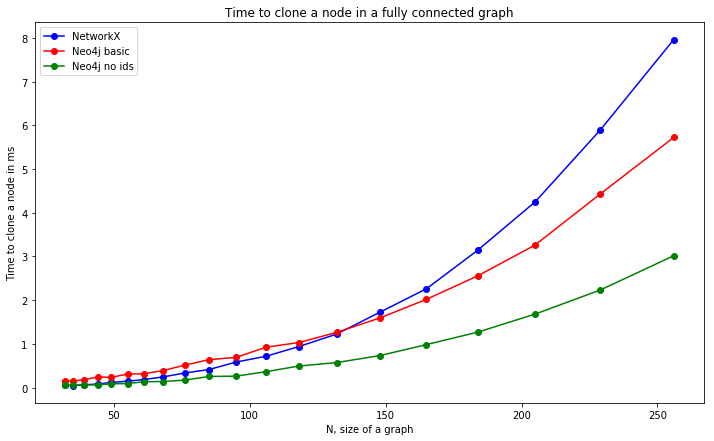

In [161]:
# plot the graph
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.plot(clique_ns, nx_clique["clone"], "bo-", clique_ns, neo4j_clique["full_clone"], "ro-", clique_ns, neo4j_clique["no_id_gen_clone"][:20], "go-")

ax.set_title('Time to clone a node in a fully connected graph')
ax.set_xlabel('N, size of a graph')
ax.set_ylabel('Time to clone a node in ms')
ax.legend(["NetworkX", "Neo4j basic", "Neo4j no ids"])

plt.show()

### Scale-free graphs (fixed params ($\alpha=0.41$, $\beta=0.54$, $\gamma=0.05$), various size)

In [162]:
# # Generate graphs (Warning: takes some time, see below dumped graphs) + TODO: investigate more parameters
# scale_free_ns = [int(i) for i in np.logspace(5, 14, 100, base=2)]

# logspaced_scale_free = []
# for n in scale_free_ns:
#     logspaced_scale_free.append(nx.scale_free_graph(n))

# # dump generated graphs
# with open("log_spaced_scale_free.pickle","wb") as f:
#     pickle.dump((scale_free_ns, logspaced_scale_free), f)

In [6]:
# load generated graphs
with open("log_spaced_scale_free.pickle","rb") as f:
    (scale_free_ns, logspaced_scale_free) = pickle.load(f)
print("Graph sizes to generate: ", scale_free_ns)

Graph sizes to generate:  [32, 34, 36, 38, 41, 43, 46, 49, 52, 56, 60, 64, 68, 72, 77, 82, 87, 93, 99, 105, 112, 120, 128, 136, 145, 154, 164, 175, 186, 198, 211, 225, 240, 256, 272, 290, 309, 329, 350, 373, 397, 423, 451, 480, 512, 545, 580, 618, 658, 701, 747, 795, 847, 902, 961, 1024, 1090, 1161, 1237, 1317, 1403, 1494, 1591, 1695, 1805, 1922, 2048, 2181, 2323, 2474, 2635, 2806, 2989, 3183, 3390, 3610, 3845, 4096, 4362, 4646, 4948, 5270, 5612, 5978, 6366, 6780, 7221, 7691, 8192, 8724, 9292, 9896, 10540, 11225, 11956, 12733, 13561, 14443, 15383]


In [16]:
# We define statistics of interest
nx_scale_free = {
    "clone": [],
    "merge": [],
    "add_node": [],
    "add_edge": [],
    "remove_node": [],
    "remove_edge": []
}
neo4j_scale_free = {
    "full_clone": [],
    "no_id_gen_clone": [],
#     "no_ignore_edges_clone": [],
    "merge": [],
    "add_node": [],
    "add_edge": [],
    "remove_node": [],
    "remove_edge": []
}

In [17]:
# np.var(largest_conected_components_sizes)
for g in logspaced_scale_free:
    print("Graph of size {}...".format(len(g.nodes())))

    graph = nx.relabel_nodes(g, {n: "n" + str(n) for n in g.nodes()})

    # dump graph into 'graph.csv'
    with open('/var/lib/neo4j/import/graph.csv', "w+") as f:
        f.write("uId,vId\n")
        for u, v in graph.edges():
            f.write("{},{}\n".format(u, v))

    # load csv into neo4j database
    neo4j_g.clear()
    load_csv_query =\
        "LOAD CSV WITH HEADERS FROM 'file:///graph.csv' AS csvLine " +\
        "MERGE (u:node {id: csvLine.uId }) " +\
        "MERGE (v:node {id: csvLine.vId }) " +\
        "CREATE (u)-[:edge]->(v) "
    neo4j_g.execute(load_csv_query)
    nodes = graph.nodes()

    # select 100 random nodes to clone
    random_nodes = np.random.choice(nodes, 100)
        
    # Clone with no pretty id's generation
    elapsed_times = []
    for node in random_nodes:
        start = time.time()
        res = neo4j_g.clone_node(node, ignore_naming=True)
        elapsed_times.append(time.time() - start)
    neo4j_scale_free["no_id_gen_clone"].append(np.mean(elapsed_times))
    
    # Clone with pretty id's generation + ignoreEdges
    elapsed_times = []
    for node in random_nodes:
        start = time.time()
        res = neo4j_g.clone_node(node)
        elapsed_times.append(time.time() - start)
    neo4j_scale_free["full_clone"].append(np.mean(elapsed_times))
    
    # Clone 100 random nodes in nx graph
    elapsed_times = []
    for node in random_nodes:
        start = time.time()
        res = clone_node(graph, node)
        elapsed_times.append(time.time() - start)
    nx_scale_free["clone"].append(np.mean(elapsed_times))

with open("nx_scale_free.pickle", "wb") as f:
    pickle.dump(nx_scale_free, f)

with open("neo4j_scale_free.pickle", "wb") as f:
    pickle.dump(neo4j_scale_free, f)

Graph of size 32...
Graph of size 34...
Graph of size 36...
Graph of size 38...
Graph of size 41...
Graph of size 43...
Graph of size 46...
Graph of size 49...
Graph of size 52...
Graph of size 56...
Graph of size 60...
Graph of size 64...
Graph of size 68...
Graph of size 72...
Graph of size 77...
Graph of size 82...
Graph of size 87...
Graph of size 93...
Graph of size 99...
Graph of size 105...
Graph of size 112...
Graph of size 120...
Graph of size 128...
Graph of size 136...
Graph of size 145...
Graph of size 154...
Graph of size 164...


KeyboardInterrupt: 

Exception ignored in: 'neo4j.bolt._io.ChunkedInputBuffer.receive'
Traceback (most recent call last):
  File "/home/eugenia/anaconda3/lib/python3.6/ssl.py", line 1009, in recv_into
    return self.read(nbytes, buffer)
  File "/home/eugenia/anaconda3/lib/python3.6/ssl.py", line 871, in read
    return self._sslobj.read(len, buffer)
  File "/home/eugenia/anaconda3/lib/python3.6/ssl.py", line 631, in read
    v = self._sslobj.read(len, buffer)
KeyboardInterrupt: 


ServiceUnavailable: Failed to read from defunct connection Address(host='127.0.0.1', port=7687)

In [ ]:
# np.var(largest_conected_components_sizes)
for g in logspaced_scale_free:
    print("Graph of size {}...".format(len(g.nodes())))

    graph = nx.relabel_nodes(g, {n: "n" + str(n) for n in g.nodes()})

    # dump graph into 'graph.csv'
    with open('/var/lib/neo4j/import/graph.csv', "w+") as f:
        f.write("uId,vId\n")
        for u, v in graph.edges():
            f.write("{},{}\n".format(u, v))

    # load csv into neo4j database
    neo4j_g.clear()
    load_csv_query =\
        "LOAD CSV WITH HEADERS FROM 'file:///graph.csv' AS csvLine " +\
        "MERGE (u:node {id: csvLine.uId }) " +\
        "MERGE (v:node {id: csvLine.vId }) " +\
        "CREATE (u)-[:edge]->(v) "
    neo4j_g.execute(load_csv_query)
    nodes = graph.nodes()

    # select 100 random pairs nodes to merge
    random_nodes1 = np.random.choice(nodes, 100)
    random_nodes1 = np.random.choice(nodes, 100) 
    
    # Merge with no pretty id's generation
    elapsed_times = []
    for i in range(len(random_nodes1)):
        node1 = random_nodes1[i]
        node2 = random_nodes2[i]
        if node1 != node2:
            start = time.time()
            res = neo4j_g.merge_nodes([node1, node2], ignore_naming=True)
            elapsed_times.append(time.time() - start)
    neo4j_scale_free["no_id_gen_merge"].append(np.mean(elapsed_times))
    
    # Clone with pretty id's generation + ignoreEdges
    elapsed_times = []
    for i in range(len(random_nodes1)):
        node1 = random_nodes1[i]
        node2 = random_nodes2[i]
        if node1 != node2:
            start = time.time()
            res = neo4j_g.merge_nodes([node1, node2], ignore_naming=True)
            elapsed_times.append(time.time() - start)
    neo4j_scale_free["full_merge"].append(np.mean(elapsed_times))
    
    # Clone 100 random nodes in nx graph
    elapsed_times = []
    for node in random_nodes:
        start = time.time()
        res = clone_node(graph, node)
        elapsed_times.append(time.time() - start)
    nx_scale_free["clone"].append(np.mean(elapsed_times))


In [ ]:
with open("nx_scale_free.pickle", "wb") as f:
    pickle.dump(nx_scale_free, f)

with open("neo4j_scale_free.pickle", "wb") as f:
    pickle.dump(neo4j_scale_free, f)

In [166]:
with open("nx_scale_free.pickle", "rb") as f:
    nx_scale_free = pickle.load(f)
with open("neo4j_scale_free.pickle", "rb") as f:
    neo4j_scale_free = pickle.load(f)

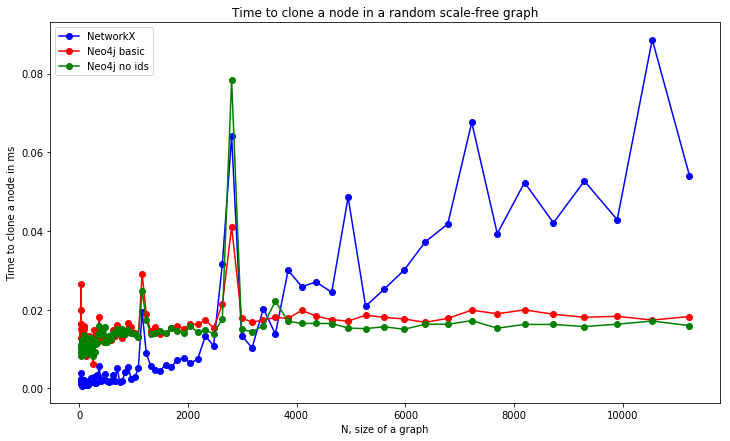

In [167]:
# plot the graph
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.plot(scale_free_ns[:94], nx_scale_free["clone"][:94], "bo-", scale_free_ns[:94], neo4j_scale_free["full_clone"][:94], "ro-", scale_free_ns[:94], neo4j_scale_free["no_id_gen_clone"][:94], "go-")

ax.set_title('Time to clone a node in a random scale-free graph')
ax.set_xlabel('N, size of a graph')
ax.set_ylabel('Time to clone a node in ms')
ax.legend(["NetworkX", "Neo4j basic", "Neo4j no ids"])

plt.show()

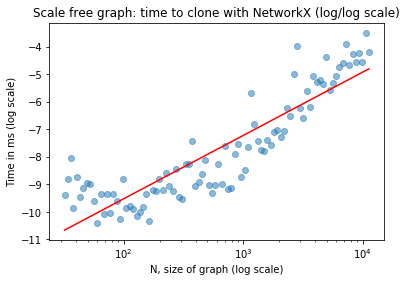

Exponent:  0.692686886568


In [168]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Scale free graph: time to clone with NetworkX (log/log scale)")
ax.set_xlabel('N, size of graph (log scale)')
ax.set_ylabel('Time in ms (log scale)')

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log2(scale_free_ns[:94]), np.log2(nx_scale_free["clone"][:94]))

ax.scatter(scale_free_ns[:94], np.log2(nx_scale_free["clone"][:94]), alpha=0.5)
ax.set_xscale('log')

x = scale_free_ns[:94]
y = [np.log2(xx**slope * 2 ** intercept) for xx in x]
ax.plot(x, y, color="red")

plt.show()
print("Exponent: ", slope)

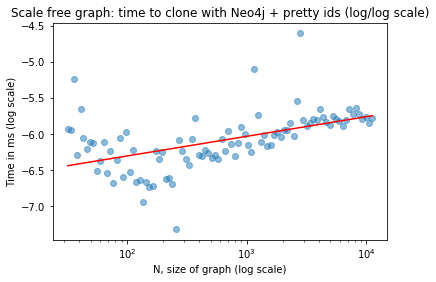

Exponent:  0.0817699130295


In [169]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Scale free graph: time to clone with Neo4j + pretty ids (log/log scale)")
ax.set_xlabel('N, size of graph (log scale)')
ax.set_ylabel('Time in ms (log scale)')

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log2(scale_free_ns[:94]), np.log2(neo4j_scale_free["full_clone"]))

ax.scatter(scale_free_ns[:94], np.log2(neo4j_scale_free["full_clone"]), alpha=0.5)
ax.set_xscale('log')

x = scale_free_ns[:94]
y = [np.log2(xx**slope * 2 ** intercept) for xx in x]
ax.plot(x, y, color="red")

plt.show()
print("Exponent: ", slope)

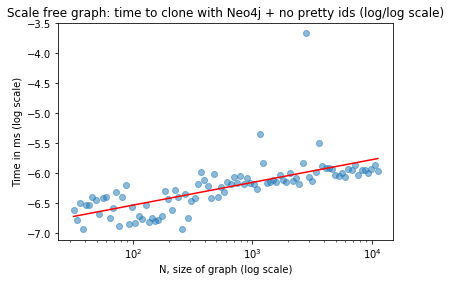

Exponent:  0.113929285555


In [170]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Scale free graph: time to clone with Neo4j + no pretty ids (log/log scale)")
ax.set_xlabel('N, size of graph (log scale)')
ax.set_ylabel('Time in ms (log scale)')

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log2(scale_free_ns[:94]), np.log2(neo4j_scale_free["no_id_gen_clone"]))

ax.scatter(scale_free_ns[:94], np.log2(neo4j_scale_free["no_id_gen_clone"]), alpha=0.5)
ax.set_xscale('log')

x = scale_free_ns[:94]
y = [np.log2(xx**slope * 2 ** intercept) for xx in x]
ax.plot(x, y, color="red")

plt.show()
print("Exponent: ", slope)